### Explore customer product purchase dataset

You have explored the customer by product purchase dataset in the video exercise and are now ready to plot some exploratory charts to understand the distribution of the variables and relationships between them. Here, you will explore the wholesale dataset and plot the pairwise relationships as well as the estimated distributions for each variable with the pairplot function from the seaborn library. It's an important step to explore the distribution types, and the relationships between the variables to inform the need for further data preprocessing.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

In [21]:
wholesale = pd.read_csv('Data/wholesale.csv')
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [22]:
wholesale.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [23]:
wholesale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicatessen        440 non-null int64
dtypes: int64(6)
memory usage: 20.8 KB


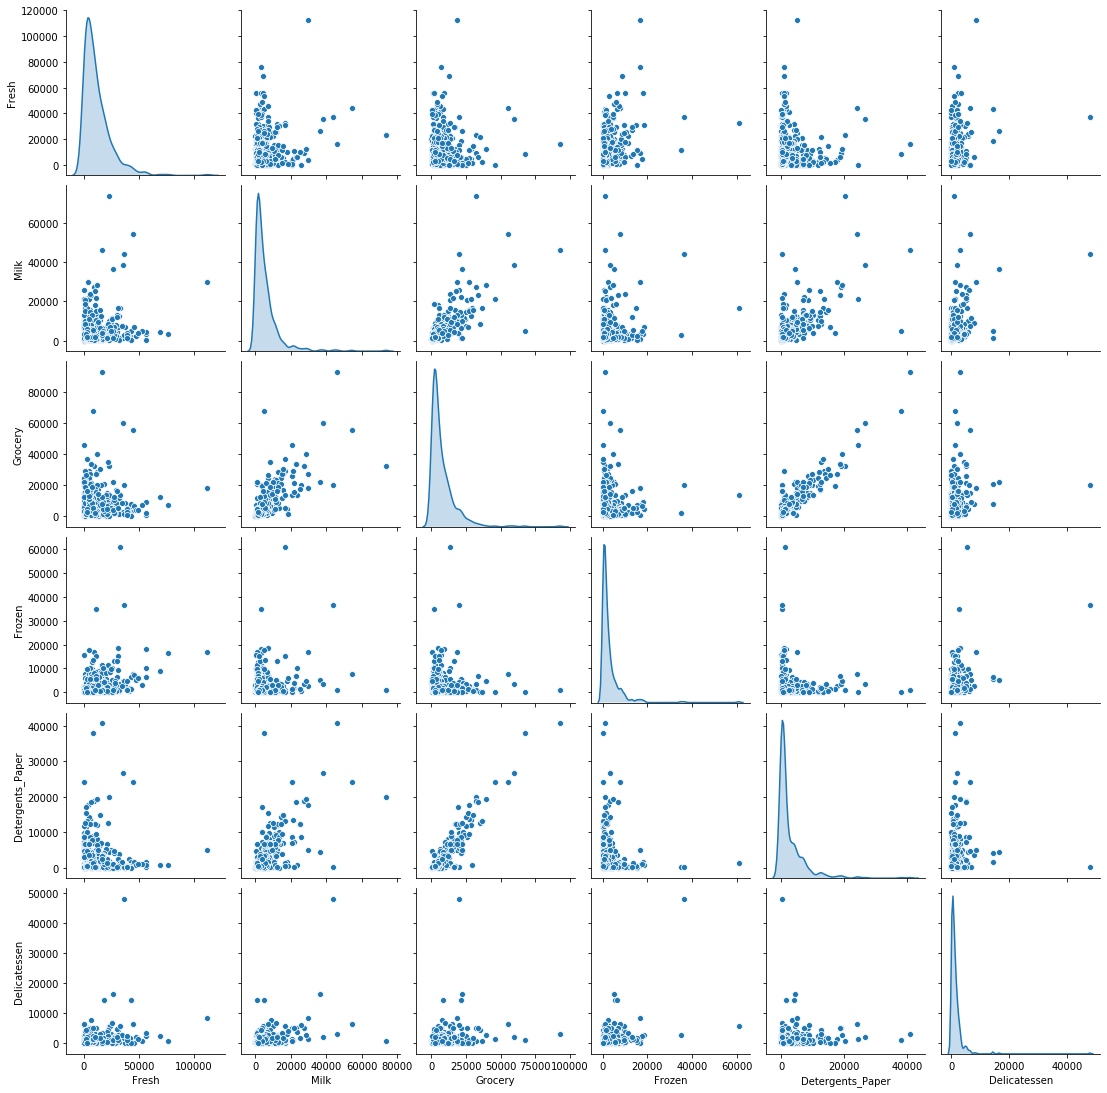

In [24]:
# Plot the pairwise relationships between the variables
sns.pairplot(wholesale, diag_kind='kde')

# Display the chart
plt.show()

* You can see that most variables have non-symmetrical distributions i.e. they are skewed

### Understand differences in variables
Now, you will analyze the averages and standard deviations of each variable by plotting them in a barplot. This is a complementary step to the one before, as you will visually explore the differences in variable scales and variances.

In [25]:
wholesale.agg(['mean','std']).round(0)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
mean,12000.0,5796.0,7951.0,3072.0,2881.0,1525.0
std,12647.0,7380.0,9503.0,4855.0,4768.0,2820.0


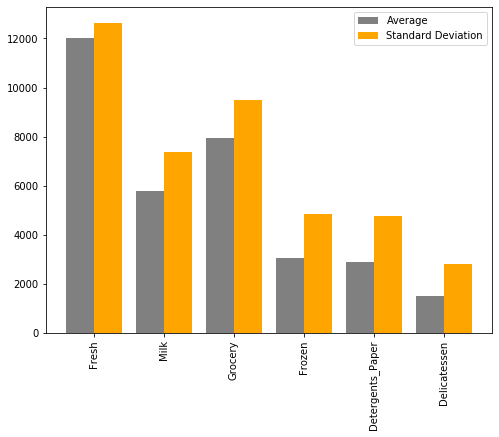

In [26]:
# Get the statistics
averages = wholesale.mean()
std_devs = wholesale.std()

# Create column names list and same length integer list
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

# Plot the averages data in gray and standard deviations in orange 
plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)

# Add x-axis labels and rotate
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)

# Add the legend and display the chart
plt.legend()
plt.show()

### Unskew the variables
You will now transform the wholesale columns using Box-Cox transformation, and then explore the pairwise relationships plot to make sure the skewness of the distributions has been reduced to make them more normal. This is a critical step to make sure the K-means algorithm converges and discovers homogeneous groups (a.k.a. clusters or segments) of observations.

In [28]:
# Second option - Box-Cox transformation
from scipy import stats

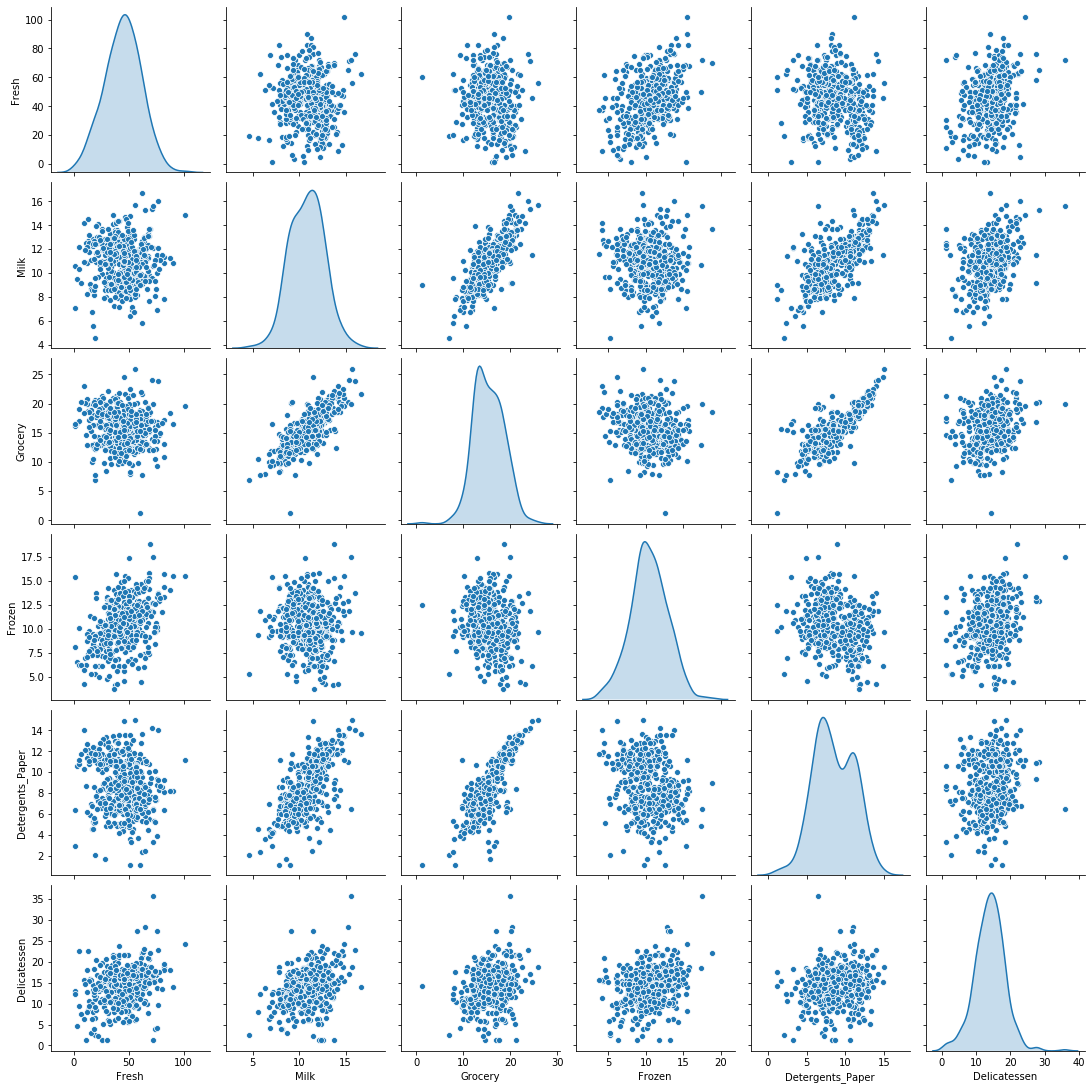

In [29]:
# Define custom Box Cox transformation function
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

# Apply the function to the `wholesale` dataset
wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

# Plot the pairwise relationships between the transformed variables 
sns.pairplot(wholesale_boxcox, diag_kind='kde')

# Display the chart
plt.show()

* By using Box-Cox transformation you have successfully unskewed the variables and they now are almost normally distributed.

### Scale the data
- Subtract column average from each column value
- Divide each column value by column standard deviation
- Will use StandardScaler() module from sklearn

### Normalize the variables
Now, for the last step in data preparation. You will transform the unskewed dataset wholesale_boxcox to the same scale, meaning all columns have a mean of zero, and standard deviation of 1. You will use the StandardScaler function from the sklearn.preprocessing module.

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the initialized `scaler` instance on the Box-Cox transformed dataset
scaler.fit(wholesale_boxcox)

# Transform and store the scaled dataset as `wholesale_scaled`
wholesale_scaled = scaler.transform(wholesale_boxcox)

# Create a `pandas` DataFrame from the scaled dataset
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                       index=wholesale_boxcox.index,
                                       columns=wholesale_boxcox.columns)

# Print the mean and standard deviation for all columns
print(wholesale_scaled_df.agg(['mean','std']).round())

      Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
mean   -0.0   0.0     -0.0    -0.0              -0.0           0.0
std     1.0   1.0      1.0     1.0               1.0           1.0


* As you can see, the averages are roughly zero, and the standard deviations are around one, which is what we wanted!

## Build customer and product segmentation

### Determine the optimal number of clusters
Here, you will use the elbow criterion method to identify the optimal number of clusters where the squared sum of error decrease becomes marginal. This is an important step to get a mathematical ball-park number of clusters to start testing. You will iterate through multiple k number of clusters and run a KMeans algorithm for each, then plot the errors against each k to identify the "elbow" where the decrease in errors slows downs.

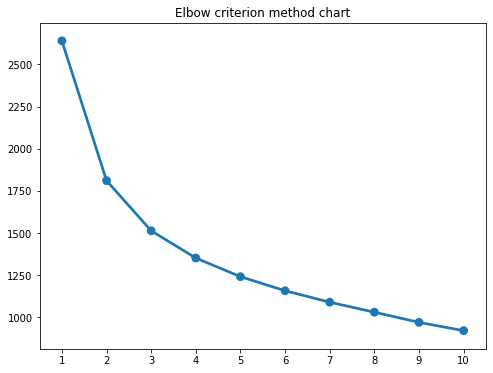

In [38]:
from sklearn.cluster import KMeans

# Create empty sse dictionary
sse = {}

# Fit KMeans algorithm on k values between 1 and 11
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

# Add the title to the plot
plt.title('Elbow criterion method chart')

# Create and display a scatter plot
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

- 4 clusters seems a good option!

### Build segmentation with k-means clustering
In this exercise, you will build the customer segmentation with KMeans algorithm. As you've identified in the previous step, the mathematically optimal number of clusters is somewhere around 3 and 4. Here, you will build one with 4 segments.

In [43]:
# Import `KMeans` module
from sklearn.cluster import KMeans

# Initialize `KMeans` with 4 clusters
kmeans=KMeans(n_clusters=4, random_state=123)

# Fit the model on the pre-processed dataset
kmeans.fit(wholesale_scaled_df)

# Assign the generated labels to a new column
wholesale_kmeans4 = wholesale.assign(segment = kmeans.labels_)
wholesale_kmeans4.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,segment
0,12669,9656,7561,214,2674,1338,3
1,7057,9810,9568,1762,3293,1776,3
2,6353,8808,7684,2405,3516,7844,3
3,13265,1196,4221,6404,507,1788,2
4,22615,5410,7198,3915,1777,5185,2


### Alternative segmentation with NMF
In this exercise, you will analyze product purchase data and identify meaningful segments using non-negative matrix factorization algorithm (NMF). It works well with sparse customer by product matrices that are typical in the e-commerce or retail space. 

In [46]:
# Import the non-negative matrix factorization module
from sklearn.decomposition import NMF

# Initialize NMF instance with 4 components
nmf = NMF(4)

# Fit the model on the wholesale sales data
nmf.fit(wholesale)

# Extract the components 
components = pd.DataFrame(data=nmf.components_, columns=wholesale.columns)
components.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,644.386601,0.000000,29.901447,0.000000,0.00000,5.271346
1,1.329201,41.730268,436.532959,3.540971,208.13507,0.000000
2,0.000000,588.637507,50.211677,0.000000,0.00000,93.633675
3,4.227933,0.000000,54.079977,409.829740,0.00000,92.708396


### Visualize and interpret segmentation solutions


### K-means segmentation averages
In this exercise, you will explore the average column values for a 3-segment solution with K-means. As part of the test & learn exploration process, visually inspecting the segmentation solutions is critical to identify the most business relevant option.

In [50]:
kmeans4_averages = wholesale_kmeans4.groupby(['segment']).mean().round(0)
print(kmeans4_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
segment                                                                   
0        10229.0   1891.0   2500.0  2403.0             449.0         741.0
1         3618.0   6645.0  11296.0   703.0            4675.0         576.0
2        26312.0   5489.0   5228.0  8342.0             830.0        3212.0
3        10453.0  12717.0  17723.0  1940.0            7684.0        2394.0


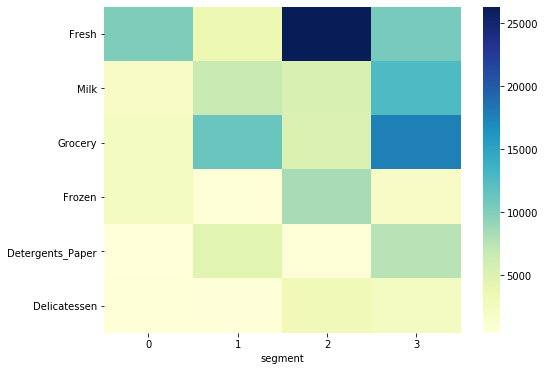

In [51]:
sns.heatmap(kmeans4_averages.T, cmap='YlGnBu')
plt.show()

### NMF segmentation averages
Finally, you will visually explore the average values of the 4-segment solution built by NMF and can compare it to the K-means one. Here you will extract the features matrix W which we will use to extract the hard segment assignment by choosing the column value (segment) with highest associated value in this matrix for each customer.

In [57]:
# Create the W matrix
segment_weights = pd.DataFrame(nmf.transform(wholesale), columns=components.index)
segment_weights.index = wholesale.index
segment_weights.head()

,0,1,2,3
0,19.634295,13.930555,15.368602,0.306790
1,10.902878,18.318526,15.374069,4.161790
2,9.831135,14.420520,15.415416,8.750253
3,20.493765,5.432579,1.707513,15.710805
4,35.059381,10.949128,9.291336,11.255828


In [58]:
# Assign the column name where the corresponding value is the largest
wholesale_nmf = wholesale.assign(segment = segment_weights.idxmax(axis=1))
wholesale_nmf.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,segment
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,0


In [59]:
# Calculate the average column values per each segment
nmf_averages = wholesale_nmf.groupby('segment').mean().round(0)
nmf_averages

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
segment,,,,,,
0,18742.0,3263.0,4063.0,3086.0,868.0,1311.0
1,5043.0,8853.0,15392.0,1326.0,6802.0,1391.0
2,4070.0,11893.0,6681.0,1918.0,2049.0,2520.0
3,7288.0,3516.0,3566.0,9959.0,522.0,2296.0


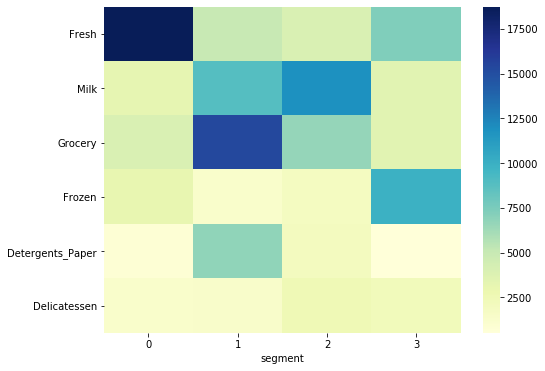

In [61]:
# Plot the average values as heatmap
sns.heatmap(nmf_averages.T, cmap='YlGnBu')

# Display the chart
plt.show()

Source: Datacamp